In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
import sys
from tqdm import tqdm

In [2]:
from b2heavy.ThreePointFunctions.utils import read_config_fit, dump_fit_object
from b2heavy.FnalHISQMetadata import params as mdata

sys.path.append('/Users/pietro/code/software/B2heavy/routines')
from routines.fit_2pts_dispersion_relation import mom_to_p2, extract_energies
from routines.fit_2pts_dispersion_relation import dispersion_relation_lsqfit as disprel
from routines.fit_2pts_dispersion_relation import dispersion_relation        as disprel_plot

In [4]:
frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'
mes = 'Dst'
JK = True
JKFIT = False

enslist = [['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys'],['Fine-1','Fine-Phys','SuperFine']]

In [5]:
def fit_disp_rel(e0:dict, Lvol=1., priors=None):
    pv = [2*np.pi/Lvol*np.array([float(px) for px in m]) for m in e0]

    psort = list(e0.keys())
    psort.sort(key=mom_to_p2)

    e0vec = np.array([e0[p] for p in psort])
    yfit = e0vec**2

    if e0vec.ndim==2:
        yfit = gv.gvar(
            yfit.mean(axis=1),
            np.cov(yfit) * (yfit.shape[-1]-1)
        )

    fit = lsqfit.nonlinear_fit(
        data  = (pv,yfit),
        fcn   = disprel,
        prior = priors
    )

    return fit


def fit_disp_rel_jk(fit:lsqfit.nonlinear_fit, e0):
    psort = list(e0.keys())
    psort.sort(key=mom_to_p2)
    e0vec = np.array([e0[p] for p in psort])
    assert e0vec.ndim==2

    yfit = e0vec**2

    aux = []
    for jk in tqdm(range(yfit.shape[-1])):
        f = lsqfit.nonlinear_fit(
            data  = (fit.x,yfit[:,jk],gv.evalcov(fit.y)),
            fcn   = fit.fcn,
            prior = fit.prior 
        )
        aux.append(f.pmean)
    df = pd.DataFrame(aux)
    fitp = gv.gvar(
        df.mean().values,
        df.cov().values*(df.shape[0]-1)
    )
    
    return {c: fitp[i] for i,c in enumerate(df.columns)}


In [6]:
def plot_disp_rel(ax,fit,popt,Lvol,**kwargs):
    p2 = np.array([sum(np.array(p)**2) for p in fit.x])
    ax.errorbar(p2,gv.mean(fit.y),gv.sdev(fit.y),**kwargs)

    plist = [np.sqrt([x/3,x/3,x/3]) for x in np.arange(0,max(p2)+0.1,0.01)]
    xplot = [sum(p**2) for p in plist]
    fitpar = [popt[k] for k in ['M1','M2','M4','w4']]
    fplot = [disprel_plot(p,*fitpar) for p in plist]
    ax.fill_between(xplot,gv.mean(fplot)-gv.sdev(fplot),gv.mean(fplot)+gv.sdev(fplot),alpha=0.2)

    dp = p2[1]-p2[0]
    ax.set_xlim(xmax=max(p2)+dp)

    de2 = abs((fit.y[-1]-fit.y[-2]).mean)
    ax.set_ylim(ymax=max(gv.mean(fit.y))+de2)


    return

In [7]:
priors = dict(
    M1 = gv.gvar(0.5,1.5),
    M2 = gv.gvar(0.5,1.5),
    M4 = gv.gvar(0.5,1.5),
    w4 = gv.gvar(0.5,1.5)
)

In [42]:
from b2heavy.FnalHISQMetadata import *

def disprel_priors(ens):
    mp = mdata(ens)

    p = {'aInv': 1/mp['aSpc']}

    lbQcd = 0.6/p['aInv']
    lsQcd = 0.4/p['aInv']


    m0D = 0.5/mp['u0']*(1./mp['kappaD'] - 1/mp['kappaCr'])
    m0B = 0.5/mp['u0']*(1./mp['kappaB'] - 1/mp['kappaCr'])

    #   c^2 = M1/M2 Speed of light prior, only for D* meson
    c2_0 = m1_0(m0D)/m2_0(m0D)                      # Tree level
    c2_1 = y2*g2(m0D) + z2*h2(m0D)                  # 1-loop correction

    p['c2']   = c2_0 + als(mp['aSpc'])*c2_1 + lbQcd*l2(m0D)
    p['c2s']  = np.sqrt((y2s*g2(m0D)*als(mp['aSpc']))**2 + (z2s*h2(m0D)*als(mp['aSpc']))**2 + (lsQcd*l2(m0D))**2)

    #   A4' = M1 x W4 prior
    cq_0 = w4_0(m0D)*m1_0(m0D)                      # Tree level
    cq_1 = y4p*g4p(m0D) + z4p*h4p(m0D)              # 1-loop correction

    p['A4p']  = (-1./3.)*(cq_0 + als(mp['aSpc'])*cq_1 + lbQcd*l4p(m0D))
    p['A4ps'] = ( 1./3.)*np.sqrt((y4ps*g4p(m0D)*als(mp['aSpc']))**2 + (z4ps*h4p(m0D)*als(mp['aSpc']))**2 + (lsQcd*l4p(m0D))**2)   # Error l2 --> l4p


    #   A4 = cp prior (A4)
    cp_0 = 1/(m2_0(m0D)*m2_0(m0D)) - m1_0(m0D)*invm4_0_cu(m0D)  # Tree level
    cp_1 = y4*g4(m0D) + z4*h4(m0D)                              # 1-loop correction

    p['A4']   = 0.25*(cp_0 + als(mp['aSpc'])*cp_1 + lbQcd*l4(m0D))       # Error 1 --> als(p['aSpc'])*cp_1
    p['A4s']  = 0.25*np.sqrt((y4s*g4(m0D)*als(mp['aSpc']))**2 + (z4s*h4(m0D)*als(mp['aSpc']))**2 + (lbQcd*l4(m0D))**2)


    pr = {'M1': gv.gvar(0.5,0.5)}
    pr['M2'] = pr['M1']/np.sqrt(p['c2'])
    pr['M4'] = (pr['M1']/(1/pr['M2']**2 - 4*p['A4'])) ** (1/3)
    pr['w4'] = 3*p['A4p']/pr['M1']

    return pr


In [44]:
disprel_priors('Coarse-1')

{'M1': 0.50(50), 'M2': 0.54(54), 'M4': 0.52(51), 'w4': -1.4(1.4)}

100%|██████████| 64/64 [00:00<00:00, 171.76it/s]


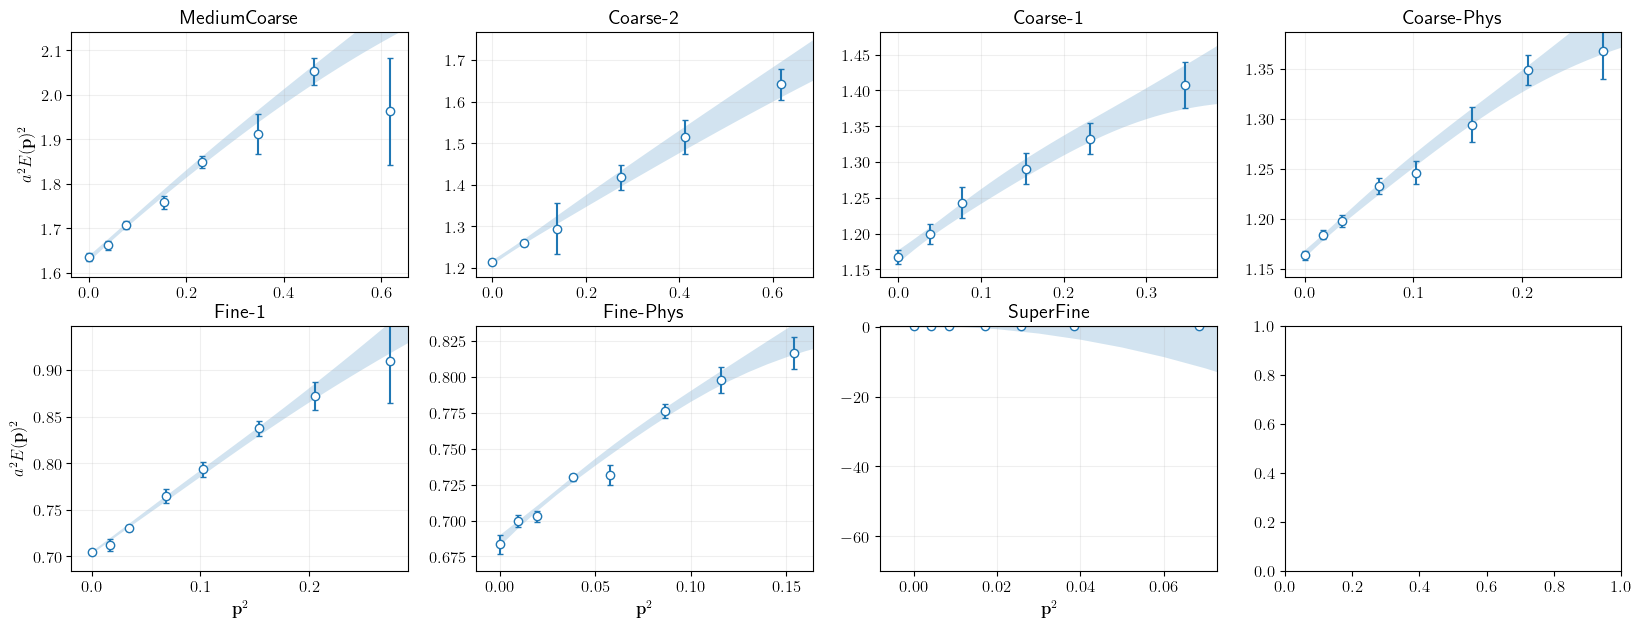

In [45]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(2,4,figsize=(20,7))

ergs = {}
moms = {}
fits = []
for i,row in enumerate(enslist):
    for j,ens in enumerate(row):
        Lvol   = mdata(ens)['L']

        tag = f'{ens}_{mes}'

        es = extract_energies(ens,mes,jk=True,readfrom=frm,sort=True)
        fit = fit_disp_rel(es, Lvol=Lvol, priors=priors)
        popt = fit_disp_rel_jk(fit,es)        

        plot_disp_rel(ax[i,j], fit, popt, Lvol=Lvol, fmt='o', ecolor='C0', mfc='w', capsize=2.5)

        fits.append(popt)
        ergs[ens] = fit.y
        moms[ens] = fit.x

        ax[i,j].set_title(ens)
        ax[i,j].grid(alpha=0.2)

        if j==0:
            ax[i,j].set_ylabel(r'$a^2 E(\mathbf{p})^2$')
        if i==1:
            ax[i,j].set_xlabel(r'$\mathbf{p}^2$')



In [46]:
res = pd.DataFrame(fits).set_index(np.concatenate(enslist))
print(res)

                       M1         M2         M4        w4
MediumCoarse   1.2772(26)  1.278(98)   1.24(39)  1.45(63)
Coarse-2       1.1013(25)   1.47(18)   1.19(29)  0.13(50)
Coarse-1       1.0807(42)   1.20(25)   0.70(21)  0.16(56)
Coarse-Phys    1.0792(17)   1.09(15)   0.72(24)  1.16(71)
Fine-1        0.83884(88)  0.977(77)   0.88(40)  0.13(61)
Fine-Phys      0.8282(23)  0.702(97)  0.452(91)  0.37(49)
SuperFine      0.5551(41)   0.43(41)   0.1(2.3)  0.54(50)


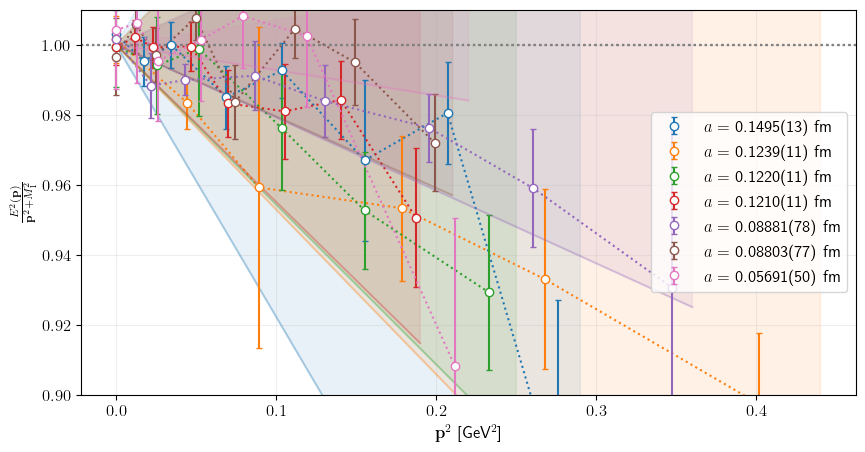

In [10]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)


for i,ens in enumerate(ergs):
    alphas = mdata(ens)['alphaS']
    a = mdata(ens)['aSpc'].mean

    es = ergs[ens]
    p2 = np.sum(np.array(moms[ens])**2,axis=1)
    
    num = es
    den = p2 + res['M1'].loc[ens]**2

    xplot = p2/a**2/100
    yplot = num/den

    lbl = r'$a=$ '+str(mdata(ens)['aSpc'])+' fm'

    ax.errorbar(xplot,gv.mean(yplot),gv.sdev(yplot),fmt='o', ecolor=f'C{i}', mfc='w', capsize=2.5,label=lbl)
    ax.plot(xplot,gv.mean(yplot),linestyle=':',marker=',',color=f'C{i}')
    ax.axhline(1.,color='gray',alpha=0.5,linestyle=':')

    endp = max(xplot)+xplot[1]
    xcone = np.arange(0,endp,0.01)
    ycone = xcone*100 * alphas * a**2
    ax.fill_between(xcone, 1+ycone,1-ycone,alpha=0.1,color=f'C{i}')
    ax.plot(xcone, 1-ycone,alpha=0.3,color=f'C{i}')

# ax.set_xlim(xmin=-0.01,xmax=endp-0.01)

ax.set_ylabel(r'$\frac{E^2(\mathbf{p})}{\mathbf{p}^2 + M_1^2}$')
# ax.set_xlabel(r'$a^2\mathbf{p}^2$')
ax.set_xlabel(r'$\mathbf{p}^2$ [GeV$^2$]')
ax.set_ylim(ymax=1.01,ymin=0.9)


ax.grid(alpha=0.2)
ax.legend()